In [546]:
import pandas as pd
import numpy as np
from pandas_datareader import data as reader
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt
import pandas_datareader
from matplotlib.ticker import PercentFormatter
from collections import Counter

In [547]:
# Useful functions to define
def log_returns(x):
    return np.log(x.pct_change() + 1)

def returns(x):
    return x.pct_change()

def cumulative_returns(x):
    return (1 + x.cumprod()) - 1

def cum_log_returns(x):
    return x.cumsum()

def linreg(x, y, cod = True):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    
    if cod:
        return model.params[0], model.params[1], model.rsquared
    else:
        return model.params[0], model.params[1]

In [548]:
# List of tickers we'll use
tickers = ['NVDA', 'MSFT', 'ENPH', 'NOC', 'SPY']

# Specify start and end dates
start_date = '2018-01-01'
end_date = '2020-02-16'

# Declare variable to hold the data we fetch
panel_data = {}

# Basic for loop: assigns keys to panel_data dictionary based on the data fetched from reader
for i in tickers:
    panel_data[i] = reader.DataReader(i, 'yahoo', start_date, end_date)
    
    # Calculate daily and cumulative returns then remove NaN
    panel_data[i]['Returns'] = log_returns(panel_data[i]['Close'])
    panel_data[i]['Cum. Returns'] = cum_log_returns(panel_data[i]['Returns'])
    panel_data[i] = panel_data[i][1:]

$\beta$ is the volatility (risk) of an asset relative to the market: $$\beta = \frac{Covariance(R_i, R_m)}{Variance(R_m)}$$

In [549]:
# There are 2 ways to calculate this. Can be done by calculating Cov(R_i, R_m)/Var(R_m), or by running a regression
beta_coefficients = {}
alphas = {}
r2 = {}

for i in tickers:
    alphas[i], beta_coefficients[i], r2[i] = linreg(panel_data[i]['Returns'], panel_data['SPY']['Returns'])

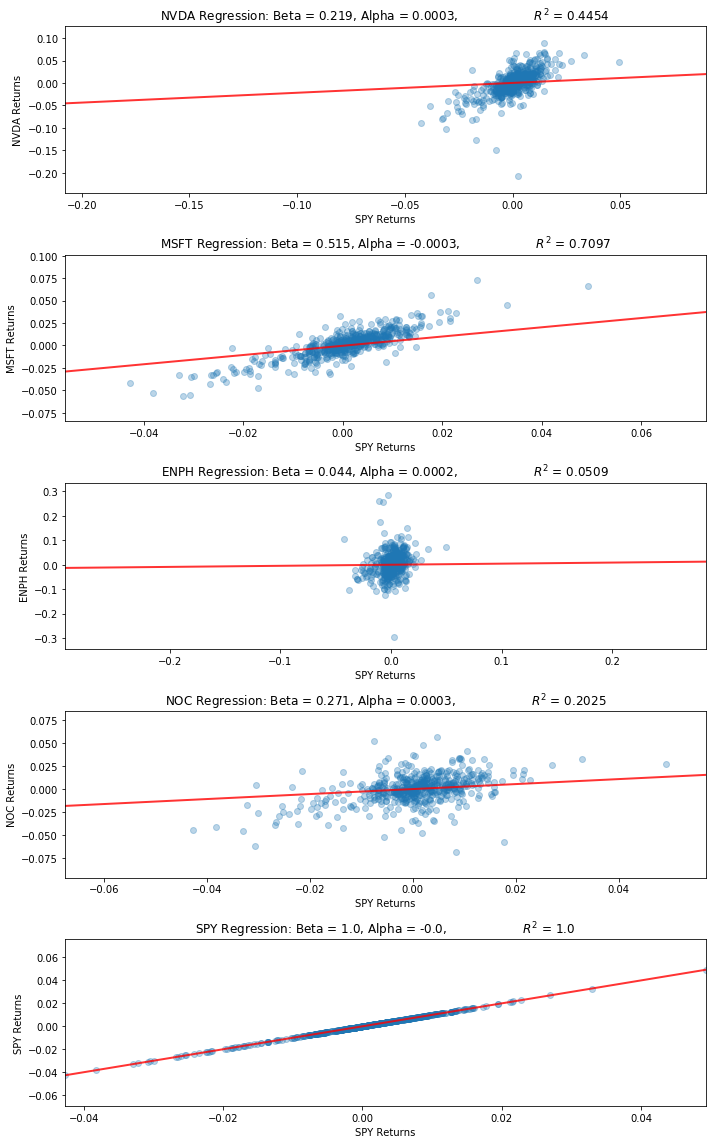

In [550]:
fig, ax = plt.subplots(len(tickers), figsize = (10, 16))

for j, i in enumerate(tickers):
    # Generate X values 
    x = np.linspace(min(panel_data[i]['Returns']), max(panel_data[i]['Returns']), len(panel_data[i]['Returns']))
    
    # Generate line of best fit
    fit_line = beta_coefficients[i] * x + alphas[i]
    
    # Plot SPY vs equity and line of best fit 
    ax[j].scatter(panel_data['SPY']['Returns'], panel_data[i]['Returns'], label = 'Returns', alpha = 0.3)
    ax[j].plot(x, fit_line, linewidth = 2, color = 'r', alpha = 0.8)
    
    # Set xlimits so we see useful stuff
    ax[j].set_xlim(min(panel_data[i]['Returns']), max(panel_data[i]['Returns']))
    
    # Labels 
    ax[j].set_ylabel(f'{i} Returns')
    ax[j].set_xlabel('SPY Returns')
    ax[j].set_title(f'{i} Regression: Beta = {np.round(beta_coefficients[i], 3)}, Alpha = {np.round(alphas[i], 4)},\
                    $R^2$ = {np.round(r2[i], 4)}')
    
    
plt.tight_layout()

The regression method is interesting for general point estimates, but in practice not that useful over large periods of time. For more information, we'll instead calculate a rolling beta: 


$$\beta_{rolling, t} = \frac{1}{\Delta{t}} \sum_{t - \Delta{t}}^{t} \beta_t$$ 



where $\Delta{t}$ is the window length and $t$ is the current point in time.

In [551]:
# These are cool but not very useful. We'll see why later. Instead, let's calculate a rolling beta
def rolling_beta(x, y, t = 100):
    cov_xy = x.rolling(window = t).cov(y)
    var_y = y.rolling(window = t).var()
    
    return cov_xy/var_y

In [552]:
rolling_betas = {}

for i in tickers:
    rolling_betas[i] = rolling_beta(panel_data[i]['Returns'], panel_data['SPY']['Returns'])

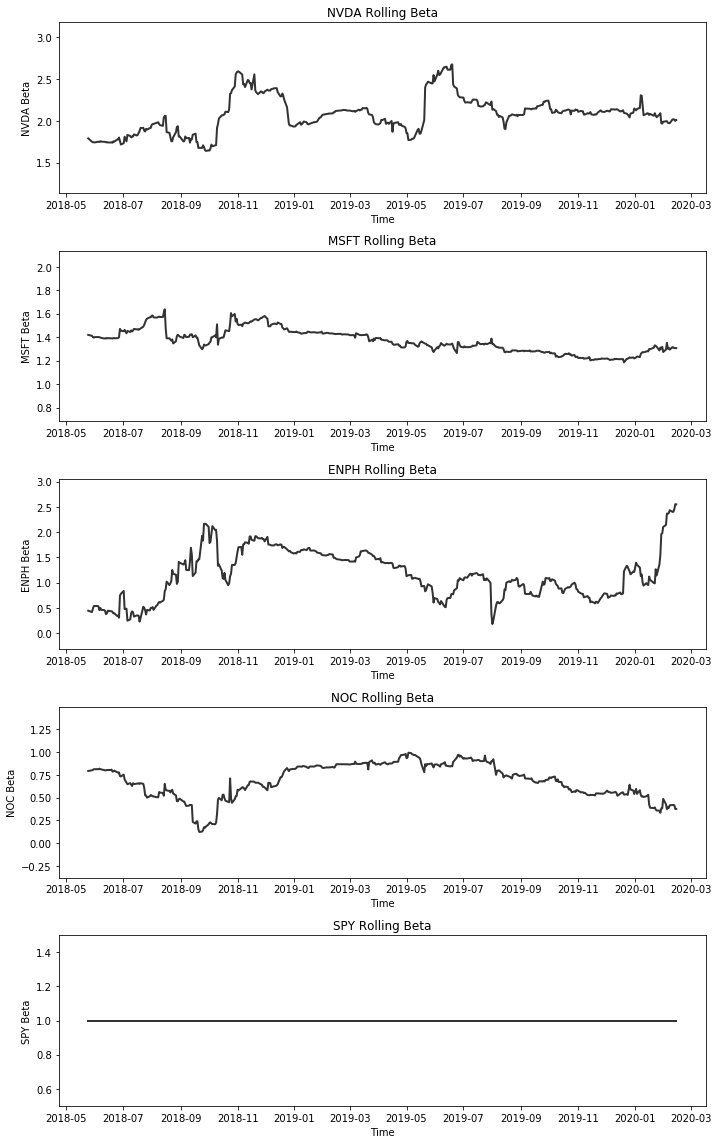

In [553]:
fig, ax = plt.subplots(len(tickers), figsize = (10, 16))

for j, i in enumerate(tickers):
    ax[j].plot(rolling_betas[i], linewidth = 2, color = 'k', alpha = 0.8)
    
    # Labels 
    ax[j].set_ylabel(f'{i} Beta')
    ax[j].set_xlabel('Time')
    ax[j].set_title(f'{i} Rolling Beta')
    
    ax[j].set_ylim(min(rolling_betas[i].dropna()) -0.5, max(rolling_betas[i].dropna()) + 0.5)
       
plt.tight_layout()

Remember, the CAPM model says: $$\texttt{E}[r_i] = \alpha + \beta_i \texttt{E}[r_m - r_f] + r_f$$

In [554]:
# Grab the 1-month T-Bill from FRED
risk_free = pandas_datareader.famafrench.FamaFrenchReader('F-F_Research_Data_Factors_daily', 
                                              start = start_date, end = end_date).read()[0]['RF']
# Adjustment since daily RF comes as a % 
risk_free = risk_free/100

# Calculate for convenience/readability
excess_market = panel_data['SPY']['Returns'] - risk_free

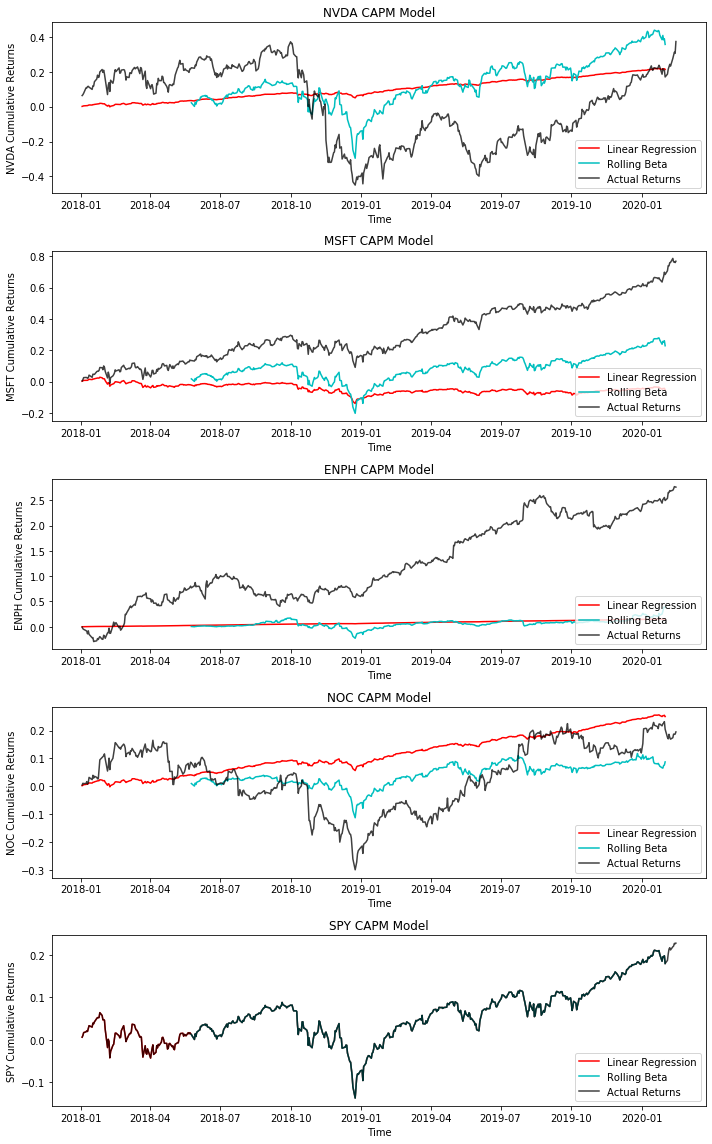

In [555]:
# Plot models 
fig, ax = plt.subplots(len(tickers), figsize = (10, 16))

for j, i in enumerate(tickers):
    ax[j].plot(panel_data[i].index, 
               (beta_coefficients[i] * excess_market + alphas[i] + risk_free).cumsum()[panel_data[i].index], 
               label = 'Linear Regression', color = 'r')
    
    ax[j].plot(rolling_betas[i].index, 
               (rolling_betas[i] * (excess_market[rolling_betas[i].index]
                                    + risk_free[rolling_betas[i].index]).cumsum()), 
               label = 'Rolling Beta', color = 'c')
    
    ax[j].plot(panel_data[i].index, panel_data[i]['Cum. Returns'], 
               label = 'Actual Returns', color = 'k', alpha = 0.75)
    
    # Labels 
    ax[j].set_ylabel(f'{i} Cumulative Returns')
    ax[j].set_xlabel('Time')
    ax[j].set_title(f'{i} CAPM Model')
    ax[j].legend(loc = 'lower right')
    
plt.tight_layout()

In [556]:
# Overall, the models performed well, but what happened with ENPH? Let's see
enph_returns = panel_data['ENPH']['Returns']
lin_reg_expectations = alphas['ENPH'] + risk_free + beta_coefficients['ENPH'] * excess_market
rolling_beta_expectations = risk_free + rolling_betas['ENPH'] * excess_market

comps = pd.concat([enph_returns, lin_reg_expectations, rolling_beta_expectations], 
                  axis = 1).dropna()
comps.columns = ['Actual', 'LinReg', 'Rolling']

In [557]:
comps['LinReg_Diff'] = comps['Actual'] - comps['LinReg']
comps['Rolling_Diff'] = comps['Actual'] - comps['Rolling']

In [558]:
print('Summary Statistics for Comps: \n')

for i in ['Actual', 'LinReg', 'Rolling']:
    print(f"{i} Mean: {np.round(np.mean(comps[i] * 100), 2)}, Stdev: {np.round(np.std(comps[i], ddof = 1) * 100, 2)}")
     
print('')

for i in ['LinReg_Diff', 'Rolling_Diff']:
    print(f"{i} Mean: {np.round(np.mean(comps[i] * 100), 2)}, Stdev: {np.round(np.std(comps[i], ddof = 1) * 100, 2)}")

Summary Statistics for Comps: 

Actual Mean: 0.4, Stdev: 4.69
LinReg Mean: 0.03, Stdev: 0.04
Rolling Mean: 0.02, Stdev: 1.22

LinReg_Diff Mean: 0.37, Stdev: 4.68
Rolling_Diff Mean: 0.38, Stdev: 4.5


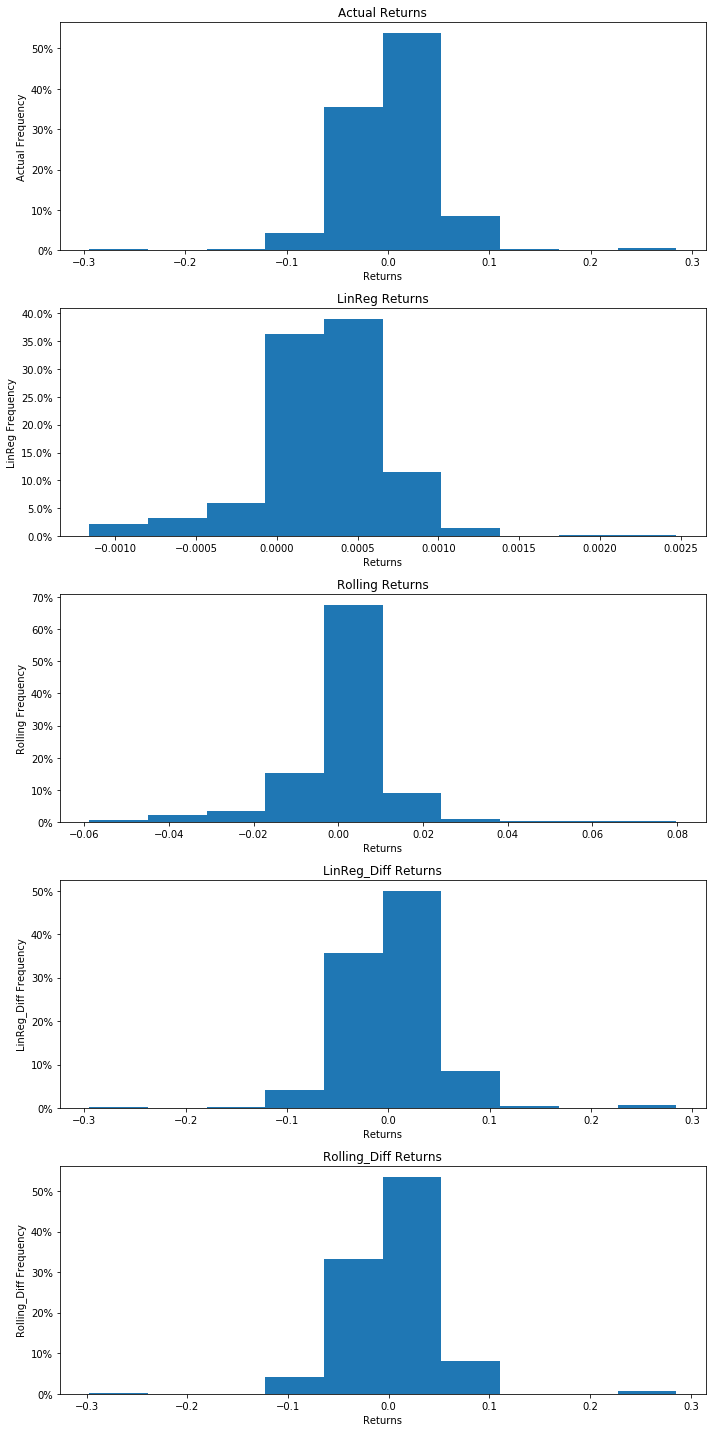

In [559]:
# Visualize These
fig, ax = plt.subplots(len(comps.columns), figsize = (10, 20))

for j, i in enumerate(comps.columns):
    ax[j].hist(comps[i].values, weights = ([Counter(comps[i])[x]/len(comps[i]) for x in comps[i]]))
    ax[j].yaxis.set_major_formatter(PercentFormatter(1))
    
    # Labels 
    ax[j].set_ylabel(f'{i} Frequency')
    ax[j].set_xlabel('Returns')
    ax[j].set_title(f'{i} Returns')
    
plt.tight_layout()

In [560]:
# What explains this next time...